<a href="https://colab.research.google.com/github/7angel4/weighted-jk/blob/main/JKGCN_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

## 0. Set up dependencies
Run the following blocks of code to install the required packages.

In [5]:
!python -c "import torch; print(torch.__version__)"

2.6.0.dev20241112


In [6]:
%%capture
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

## 1. Oversmoothing

We aim to investigate **oversmoothing**: we will consider different number of layers and visualise the corresponding node embeddings. Specifically, we will experiment using the following dataset and methods::

1.   Dataset: CORA
2.   Model: Graph Convolutional Network
3.   Dimensionality reduction method: T-SNE

#### Import required packages

Please run the below code block to import the required python packages.

In [204]:
import torch
import os
import typing
import torch_geometric

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.datasets as datasets

from torch_geometric.nn import GCNConv

In [33]:
torch.manual_seed(77888) # set seed

In [294]:
%run datasets.ipynb

In [295]:
%run models.ipynb

## 2. `train` and `evaluate` functions for training a node classification model.

- Apply **Early-stopping**: stop training if the validation accuracy decreases during *k* consecutive epochs.
- Use **Adam optimizer** for training.
- Use **evaluate** function for calculating the validation accuracy in every epoch to adapt early-stopping.

In [281]:
import torch.optim as optim
from torch_geometric.data import Data
from sklearn.metrics import f1_score

In [299]:
def evaluate(model, data, mask):
    """
    Evaluates model and returns its validation accuracy, 
    micro-F1 and macro-F1 scores on given mask.
    """
    model.eval()  # set to evaluation mode
    with torch.no_grad():  # disable gradient computation during evaluation
        # forward pass
        out = model(data.x, data.edge_index)
        # predict the class with max score
        pred = out.argmax(dim=1)
        true_labels = data.y[mask]
        
        # calculate accuracy
        correct = pred[mask] == true_labels
        accuracy = correct.sum() / mask.sum()

        # calculate F1 scores (`f1_score` expects the inputs to be on the CPU)
        micro_f1 = f1_score(true_labels.cpu(), pred[mask].cpu(), average='micro')
        macro_f1 = f1_score(true_labels.cpu(), pred[mask].cpu(), average='macro')

    return accuracy, micro_f1, macro_f1

In [300]:
def init_training(params):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    data, dataset = load_data(params['dataset'], data_only=False)
    params["n_classes"] = dataset.num_classes  # number of target classes
    params["input_dim"] = dataset.num_features  # size of input features
    
    model = set_model(params, device)
    model.param_init()
    
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])
    loss_fn = nn.CrossEntropyLoss()
    
    return model, data, optimizer, loss_fn

In [301]:
def train(params: typing.Dict,
          report_per_period=10) -> torch.nn.Module:
    """
    Trains a node classification model and
    returns the trained model object.
    """
    model, data, optimizer, loss_fn = init_training(params)
    n_epochs = params['epochs']

    # variables for early stopping
    best_val_acc = 0  # best validation accuracy
    prev_loss = float('inf')
    epochs_dec_acc = 0  # number of consecutive epochs with decreasing validation accuracy
    # k: stop if epochs_dec_acc >= patience
    patience = params['max_patience']

    # standard training with backpropagation
    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index) # forward pass
        loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
        loss.backward() # backward pass
        optimizer.step()

        # evaluate on validation set
        val_acc = evaluate(model, data, data.val_mask)[0]

        # early stopping
        if val_acc >= best_val_acc:
            best_val_acc = val_acc
            epochs_dec_acc = 0
        else:
            epochs_dec_acc += 1

        # patience exceeded -> stop training
        if epochs_dec_acc >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            print(f"Best validation accuracy: {best_val_acc}")
            break

        # print training progress
        if epoch % report_per_period == 0:
            print(f"Epoch {epoch + 1}/{n_epochs}...")
            print(f"Loss: {loss};")
            print(f"Validation Accuracy: {val_acc}\n")

    return model

In [302]:
TRAIN_LAYERS = range(2,21,3)
VIS_LAYERS = range(2,21,6)

#### 3.1. Train 4 GCN models with varying number of layers.

In [303]:
def train_varying_layers_model(params=default_training_params,
                               layers=TRAIN_LAYERS,
                               report_per_period=100):
    n_layers_model = dict()
    for n in layers:
        params['n_layers'] = n
        n_layers_model[n] = train(params, report_per_period=report_per_period)
    return n_layers_model

## Testing

In [304]:
def test(model, dataset_name):
    data = load_data(dataset_name, data_only=True)
    return evaluate(model, data, data.test_mask)

In [306]:
def train_and_test(params, print_results=True, export_results=True):
    dataset_name = params['dataset']
    n_layers_models = train_varying_layers_model(params=params)
    n_layers_results = dict()
    for n, model in n_layers_models.items():
        n_layers_results[n] = test(model, dataset_name)

    if print_results:
        print(f"Test results for {params['model_name']} on {dataset_name}:")
        for n, (accuracy, micro_f1, macro_f1) in n_layers_results.items():
            print(f"{n}-layer model:")
            print(f"  accuracy = {accuracy}")
            print(f"  micro_f1 = {micro_f1}")
            print(f"  macro_f1 = {macro_f1}")
        print()

    if export_results:
        export_dir = f"results/{dataset_name}/{params['model_name']}/"      
        # export model as .pt files
        model_path = export_dir + f"{n}_layers_model.pt"
        for n, model in n_layers_models.items():
            torch.save(model, model_path)
        
        # Save results
        results_path = export_dir + f"{n}_layers_results.json"
        with open(results_path, 'w') as fp:
            json.dump({n: {'accuracy': float(acc), 
                           'micro_f1': float(mif1), 
                           'macro_f1': float(maf1)} 
                       for n, (acc, mif1, maf1) in n_layers_results.items()}, fp, indent=4)
        
    return n_layers_models, n_layers_results

In [ ]:
gcn_training_params = {
    "lr": 0.01,  # learning rate
    "weight_decay": 0.0005,  # weight_decay
    "epochs": 1000,  # number of total training epochs
    "max_patience": 5, # number of k for early stopping
    "hid_dim": 64, # size of hidden features
    "n_layers": 100, # number of layers
    "model_name": "GCN",
    "init_res_weight": 0.3,
    "dropout_ratio": 0.3,
    "dataset": "PubMed"
}
gcn_results = train_and_test(gcn_training_params)

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1/1000...
Loss: 1.097843050956726;
Validation Accuracy: 0.44600000977516174

Early stopping at epoch 25
Best validation accuracy: 0.7480000257492065
Epoch 1/1000...
Loss: 1.098351001739502;
Validation Accuracy: 0.414000004529953



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [273]:
gcn_results

({2: GCN(
    (layers): ModuleList(
      (0): GCNConv(500, 64)
      (1): GCNConv(64, 64)
    )
    (mlp): Linear(in_features=64, out_features=3, bias=True)
  ),
  5: GCN(
    (layers): ModuleList(
      (0): GCNConv(500, 64)
      (1-4): 4 x GCNConv(64, 64)
    )
    (mlp): Linear(in_features=64, out_features=3, bias=True)
  ),
  8: GCN(
    (layers): ModuleList(
      (0): GCNConv(500, 64)
      (1-7): 7 x GCNConv(64, 64)
    )
    (mlp): Linear(in_features=64, out_features=3, bias=True)
  ),
  11: GCN(
    (layers): ModuleList(
      (0): GCNConv(500, 64)
      (1-10): 10 x GCNConv(64, 64)
    )
    (mlp): Linear(in_features=64, out_features=3, bias=True)
  ),
  14: GCN(
    (layers): ModuleList(
      (0): GCNConv(500, 64)
      (1-13): 13 x GCNConv(64, 64)
    )
    (mlp): Linear(in_features=64, out_features=3, bias=True)
  ),
  17: GCN(
    (layers): ModuleList(
      (0): GCNConv(500, 64)
      (1-16): 16 x GCNConv(64, 64)
    )
    (mlp): Linear(in_features=64, out_features=3,

In [ ]:
gcn_results

In [162]:
sgcn_training_params = {
    "lr": 0.01,  # learning rate
    "weight_decay": 0.0005,  # weight_decay
    "epochs": 1000,  # number of total training epochs
    "max_patience": 5, # number of k for early stopping
    "hid_dim": 64, # size of hidden features
    "n_layers": 100, # number of layers
    "model_name": "SkipGCN",
    "init_res_weight": 0.3,
    "dropout_ratio": 0.3,
    "dataset": "Cora"
}
sgcn_results = train_and_test(sgcn_training_params)

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1/1000...
Loss: 1.9425288438796997;
Validation Accuracy: 0.3700000047683716



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1/1000...
Loss: 1.9539363384246826;
Validation Accuracy: 0.42399999499320984



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1/1000...
Loss: 2.2345142364501953;
Validation Accuracy: 0.057999998331069946



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1/1000...
Loss: 6.4565277099609375;
Validation Accuracy: 0.12200000137090683



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1/1000...
Loss: 21.647369384765625;
Validation Accuracy: 0.05999999865889549



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1/1000...
Loss: 46.25682067871094;
Validation Accuracy: 0.057999998331069946



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1/1000...
Loss: 223.38475036621094;
Validation Accuracy: 0.052000001072883606

Test results for SkipGCN:
2-layer model:
  accuracy = 0.7289999723434448
  micro_f1 = 0.729
  macro_f1 = 0.7246129017569796
5-layer model:
  accuracy = 0.7020000219345093
  micro_f1 = 0.702
  macro_f1 = 0.7055790932754774
8-layer model:
  accuracy = 0.6850000023841858
  micro_f1 = 0.685
  macro_f1 = 0.6874687375929438
11-layer model:
  accuracy = 0.6190000176429749
  micro_f1 = 0.619
  macro_f1 = 0.6295005358170533
14-layer model:
  accuracy = 0.4320000112056732
  micro_f1 = 0.432
  macro_f1 = 0.4293395874041911
17-layer model:
  accuracy = 0.40400001406669617
  micro_f1 = 0.404
  macro_f1 = 0.3840115360423763
20-layer model:
  accuracy = 0.2290000021457672
  micro_f1 = 0.229
  macro_f1 = 0.23047731523456344



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data

In [163]:
sgcn_results

({2: SkipGCN(
    (layers): ModuleList(
      (0): GCNConv(1433, 64)
      (1): GCNConv(64, 64)
    )
    (mlp): Linear(in_features=64, out_features=7, bias=True)
  ),
  5: SkipGCN(
    (layers): ModuleList(
      (0): GCNConv(1433, 64)
      (1-4): 4 x GCNConv(64, 64)
    )
    (mlp): Linear(in_features=64, out_features=7, bias=True)
  ),
  8: SkipGCN(
    (layers): ModuleList(
      (0): GCNConv(1433, 64)
      (1-7): 7 x GCNConv(64, 64)
    )
    (mlp): Linear(in_features=64, out_features=7, bias=True)
  ),
  11: SkipGCN(
    (layers): ModuleList(
      (0): GCNConv(1433, 64)
      (1-10): 10 x GCNConv(64, 64)
    )
    (mlp): Linear(in_features=64, out_features=7, bias=True)
  ),
  14: SkipGCN(
    (layers): ModuleList(
      (0): GCNConv(1433, 64)
      (1-13): 13 x GCNConv(64, 64)
    )
    (mlp): Linear(in_features=64, out_features=7, bias=True)
  ),
  17: SkipGCN(
    (layers): ModuleList(
      (0): GCNConv(1433, 64)
      (1-16): 16 x GCNConv(64, 64)
    )
    (mlp): Linear(i

In [160]:
wsgcn_training_params = {
    "lr": 0.01,  # learning rate
    "weight_decay": 0.0005,  # weight_decay
    "epochs": 1000,  # number of total training epochs
    "max_patience": 5, # number of k for early stopping
    "hid_dim": 64, # size of hidden features
    "n_layers": 100, # number of layers
    "model_name": "WeightedSkipGCN",
    "init_res_weight": 0.3,
    "dropout_ratio": 0.3,
    "dataset": "Cora"
}
wsgcn_results = train_and_test(wsgcn_training_params)

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
Epoch 1/1000...
Loss: 1.9378235340118408;
Validation Accuracy: 0.6200000047683716

current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residua

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


current residual weight: Parameter containing:
tensor(0.2973, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3052, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3052, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3135, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3135, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3224, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3224, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3315, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3315, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3402, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3402, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3483, requires_grad=True)
current residual

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


current residual weight: Parameter containing:
tensor(0.2937, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3007, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3007, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3088, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3088, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3173, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3173, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3262, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3262, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3354, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3354, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3448, requires_grad=True)
current residual

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2900, requires_grad=True)
Epoch 1/1000...
Loss: 2.0372273921966553;
Validation Accuracy: 0.12399999797344208

current residual weight: Parameter containing:
tensor(0.2900, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2808, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2808, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2718, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2718, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2646, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2646, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2608, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2608, requires_grad=True)
current residu

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


current residual weight: Parameter containing:
tensor(0.2900, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2800, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2800, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2717, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2717, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2652, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2652, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2591, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2591, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2527, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2527, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2466, requires_grad=True)
current residual

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2900, requires_grad=True)
Epoch 1/1000...
Loss: 2.6844098567962646;
Validation Accuracy: 0.07400000095367432

current residual weight: Parameter containing:
tensor(0.2900, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2814, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2814, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2744, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2744, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2686, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2686, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2638, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2638, requires_grad=True)
current residu

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Parameter containing:
tensor(0.2900, requires_grad=True)
Epoch 1/1000...
Loss: 2.995831251144409;
Validation Accuracy: 0.16200000047683716

current residual weight: Parameter containing:
tensor(0.2900, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2821, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2821, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2752, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2752, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2688, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2688, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2633, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2633, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2587, requires_grad=True)
current residual weight: Parameter conta

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data

In [167]:
wsgcn_results

({2: WeightedSkipGCN(
    (layers): ModuleList(
      (0): GCNConv(1433, 64)
      (1): GCNConv(64, 64)
    )
    (mlp): Linear(in_features=64, out_features=7, bias=True)
  ),
  5: WeightedSkipGCN(
    (layers): ModuleList(
      (0): GCNConv(1433, 64)
      (1-4): 4 x GCNConv(64, 64)
    )
    (mlp): Linear(in_features=64, out_features=7, bias=True)
  ),
  8: WeightedSkipGCN(
    (layers): ModuleList(
      (0): GCNConv(1433, 64)
      (1-7): 7 x GCNConv(64, 64)
    )
    (mlp): Linear(in_features=64, out_features=7, bias=True)
  ),
  11: WeightedSkipGCN(
    (layers): ModuleList(
      (0): GCNConv(1433, 64)
      (1-10): 10 x GCNConv(64, 64)
    )
    (mlp): Linear(in_features=64, out_features=7, bias=True)
  ),
  14: WeightedSkipGCN(
    (layers): ModuleList(
      (0): GCNConv(1433, 64)
      (1-13): 13 x GCNConv(64, 64)
    )
    (mlp): Linear(in_features=64, out_features=7, bias=True)
  ),
  17: WeightedSkipGCN(
    (layers): ModuleList(
      (0): GCNConv(1433, 64)
      (1-16)

In [270]:
jkgcn_training_params = {
    "lr": 0.01,  # learning rate
    "weight_decay": 0.0005,  # weight_decay
    "epochs": 1000,  # number of total training epochs
    "max_patience": 5, # number of k for early stopping
    "hid_dim": 64, # size of hidden features
    "n_layers": 100, # number of layers
    "model_name": "JumpKnowGCN",
    "init_res_weight": 0.3,
    "dropout_ratio": 0.3,
    "dataset": "Cora"
}
jkgcn_results = train_and_test(jkgcn_training_params)

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1/1000...
Loss: 4.153476715087891;
Validation Accuracy: 0.4000000059604645

Early stopping at epoch 19
Best validation accuracy: 0.8059999942779541
Epoch 1/1000...
Loss: 4.16123628616333;
Validation Accuracy: 0.1599999964237213



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Early stopping at epoch 35
Best validation accuracy: 0.7919999957084656
Epoch 1/1000...
Loss: 4.157581806182861;
Validation Accuracy: 0.12200000137090683



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Early stopping at epoch 9
Best validation accuracy: 0.3160000145435333
Epoch 1/1000...
Loss: 4.1607489585876465;
Validation Accuracy: 0.15600000321865082



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Early stopping at epoch 11
Best validation accuracy: 0.3160000145435333
Epoch 1/1000...
Loss: 4.159603118896484;
Validation Accuracy: 0.057999998331069946



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Early stopping at epoch 19
Best validation accuracy: 0.3160000145435333
Epoch 1/1000...
Loss: 4.158820629119873;
Validation Accuracy: 0.16200000047683716



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Early stopping at epoch 9
Best validation accuracy: 0.3160000145435333
Epoch 1/1000...
Loss: 4.1587090492248535;
Validation Accuracy: 0.12200000137090683



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Early stopping at epoch 18
Best validation accuracy: 0.3160000145435333
Test results for JumpKnowGCN:
2-layer model:
  accuracy = 0.7699999809265137
  micro_f1 = 0.77
  macro_f1 = 0.7720504398979676
5-layer model:
  accuracy = 0.7829999923706055
  micro_f1 = 0.783
  macro_f1 = 0.7808088442510296
8-layer model:
  accuracy = 0.14900000393390656
  micro_f1 = 0.149
  macro_f1 = 0.03705085167226159
11-layer model:
  accuracy = 0.10300000011920929
  micro_f1 = 0.103
  macro_f1 = 0.026680481802875276
14-layer model:
  accuracy = 0.14900000393390656
  micro_f1 = 0.149
  macro_f1 = 0.03705085167226159
17-layer model:
  accuracy = 0.09099999815225601
  micro_f1 = 0.091
  macro_f1 = 0.02383134738771769
20-layer model:
  accuracy = 0.14900000393390656
  micro_f1 = 0.149
  macro_f1 = 0.03705085167226159



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data

In [271]:
jkgcn_results

({2: JumpKnowGCN(
    (layers): ModuleList(
      (0): GCNConv(1433, 64)
      (1): GCNConv(64, 64)
    )
    (mlp): Linear(in_features=64, out_features=7, bias=True)
  ),
  5: JumpKnowGCN(
    (layers): ModuleList(
      (0): GCNConv(1433, 64)
      (1-4): 4 x GCNConv(64, 64)
    )
    (mlp): Linear(in_features=64, out_features=7, bias=True)
  ),
  8: JumpKnowGCN(
    (layers): ModuleList(
      (0): GCNConv(1433, 64)
      (1-7): 7 x GCNConv(64, 64)
    )
    (mlp): Linear(in_features=64, out_features=7, bias=True)
  ),
  11: JumpKnowGCN(
    (layers): ModuleList(
      (0): GCNConv(1433, 64)
      (1-10): 10 x GCNConv(64, 64)
    )
    (mlp): Linear(in_features=64, out_features=7, bias=True)
  ),
  14: JumpKnowGCN(
    (layers): ModuleList(
      (0): GCNConv(1433, 64)
      (1-13): 13 x GCNConv(64, 64)
    )
    (mlp): Linear(in_features=64, out_features=7, bias=True)
  ),
  17: JumpKnowGCN(
    (layers): ModuleList(
      (0): GCNConv(1433, 64)
      (1-16): 16 x GCNConv(64, 64)
 

## For other datasets

In [241]:
gcn_pubmed_params = {
    "lr": 0.01,  # learning rate
    "weight_decay": 0.0005,  # weight_decay
    "epochs": 1000,  # number of total training epochs
    "max_patience": 5, # number of k for early stopping
    "hid_dim": 64, # size of hidden features
    "n_layers": 100, # number of layers
    "model_name": "GCN",
    "init_res_weight": 0.3,
    "dropout_ratio": 0.3,
    "dataset": "PubMed"
}
gcn_pubmed_results = train_and_test(gcn_pubmed_params)

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1/1000...
Loss: 1.0970613956451416;
Validation Accuracy: 0.43799999356269836

Early stopping at epoch 16
Best validation accuracy: 0.7639999985694885
Epoch 1/1000...
Loss: 1.0987918376922607;
Validation Accuracy: 0.19599999487400055



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Early stopping at epoch 23
Best validation accuracy: 0.7940000295639038


/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1/1000...
Loss: 1.098437786102295;
Validation Accuracy: 0.19599999487400055

Early stopping at epoch 25
Best validation accuracy: 0.8100000023841858


/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1/1000...
Loss: 1.0985125303268433;
Validation Accuracy: 0.19599999487400055

Early stopping at epoch 20
Best validation accuracy: 0.5680000185966492


/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1/1000...
Loss: 1.0986137390136719;
Validation Accuracy: 0.3580000102519989

Early stopping at epoch 11
Best validation accuracy: 0.41600000858306885


/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1/1000...
Loss: 1.0986040830612183;
Validation Accuracy: 0.19599999487400055

Early stopping at epoch 11
Best validation accuracy: 0.4339999854564667


/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1/1000...
Loss: 1.0986144542694092;
Validation Accuracy: 0.19599999487400055

Early stopping at epoch 11
Best validation accuracy: 0.40799999237060547


/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data

Test results for GCN:
2-layer model:
  accuracy = 0.7639999985694885
  micro_f1 = 0.764
  macro_f1 = 0.7637594006685081
5-layer model:
  accuracy = 0.7720000147819519
  micro_f1 = 0.772
  macro_f1 = 0.7618457889871636
8-layer model:
  accuracy = 0.7419999837875366
  micro_f1 = 0.742
  macro_f1 = 0.7337001084006931
11-layer model:
  accuracy = 0.5410000085830688
  micro_f1 = 0.541
  macro_f1 = 0.5400835929610318
14-layer model:
  accuracy = 0.18000000715255737
  micro_f1 = 0.18
  macro_f1 = 0.1016949152542373
17-layer model:
  accuracy = 0.4359999895095825
  micro_f1 = 0.436
  macro_f1 = 0.25024497671726426
20-layer model:
  accuracy = 0.35199999809265137
  micro_f1 = 0.352
  macro_f1 = 0.23537934997127086



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [242]:
sgcn_pubmed_params = {
    "lr": 0.01,  # learning rate
    "weight_decay": 0.0005,  # weight_decay
    "epochs": 1000,  # number of total training epochs
    "max_patience": 5, # number of k for early stopping
    "hid_dim": 64, # size of hidden features
    "n_layers": 100, # number of layers
    "model_name": "SkipGCN",
    "init_res_weight": 0.3,
    "dropout_ratio": 0.3,
    "dataset": "PubMed"
}
sgcn_pubmed_results = train_and_test(sgcn_pubmed_params)

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1/1000...
Loss: 1.096877932548523;
Validation Accuracy: 0.421999990940094

Early stopping at epoch 28
Best validation accuracy: 0.7739999890327454
Epoch 1/1000...
Loss: 1.0996105670928955;
Validation Accuracy: 0.28999999165534973



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Early stopping at epoch 21
Best validation accuracy: 0.7820000052452087


/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1/1000...
Loss: 1.1058471202850342;
Validation Accuracy: 0.19599999487400055

Early stopping at epoch 17
Best validation accuracy: 0.7699999809265137


/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1/1000...
Loss: 1.1115334033966064;
Validation Accuracy: 0.19599999487400055

Early stopping at epoch 32
Best validation accuracy: 0.777999997138977


/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1/1000...
Loss: 1.1956161260604858;
Validation Accuracy: 0.19599999487400055

Early stopping at epoch 28
Best validation accuracy: 0.5899999737739563


/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1/1000...
Loss: 9.72187614440918;
Validation Accuracy: 0.3880000114440918

Early stopping at epoch 16
Best validation accuracy: 0.41600000858306885


/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1/1000...
Loss: 23.008543014526367;
Validation Accuracy: 0.19599999487400055

Early stopping at epoch 18
Best validation accuracy: 0.41600000858306885


/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data

Test results for SkipGCN:
2-layer model:
  accuracy = 0.7630000114440918
  micro_f1 = 0.763
  macro_f1 = 0.7626619411089871
5-layer model:
  accuracy = 0.7480000257492065
  micro_f1 = 0.748
  macro_f1 = 0.7328764558577827
8-layer model:
  accuracy = 0.6740000247955322
  micro_f1 = 0.674
  macro_f1 = 0.6757162956206272
11-layer model:
  accuracy = 0.7310000061988831
  micro_f1 = 0.731
  macro_f1 = 0.7220208662872042
14-layer model:
  accuracy = 0.45899999141693115
  micro_f1 = 0.459
  macro_f1 = 0.46233622913056865
17-layer model:
  accuracy = 0.18000000715255737
  micro_f1 = 0.18
  macro_f1 = 0.1016949152542373
20-layer model:
  accuracy = 0.41600000858306885
  micro_f1 = 0.416
  macro_f1 = 0.20587301587301587



In [243]:
wsgcn_pubmed_params = {
    "lr": 0.01,  # learning rate
    "weight_decay": 0.0005,  # weight_decay
    "epochs": 1000,  # number of total training epochs
    "max_patience": 5, # number of k for early stopping
    "hid_dim": 64, # size of hidden features
    "n_layers": 100, # number of layers
    "model_name": "WeightedSkipGCN",
    "init_res_weight": 0.3,
    "dropout_ratio": 0.3,
    "dataset": "PubMed"
}
wsgcn_pubmed_results = train_and_test(wsgcn_pubmed_params)

current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
Epoch 1/1000...
Loss: 1.0982640981674194;
Validation Accuracy: 0.40799999237060547

current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)


/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


current residual weight: Parameter containing:
tensor(0.2900, requires_grad=True)
Epoch 1/1000...
Loss: 1.1004596948623657;
Validation Accuracy: 0.19599999487400055

current residual weight: Parameter containing:
tensor(0.2900, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2960, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2960, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3033, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3033, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3108, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3108, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3187, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3187, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3270, requires_grad=True)
current residu

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


current residual weight: Parameter containing:
tensor(0.2900, requires_grad=True)
Epoch 1/1000...
Loss: 1.0972363948822021;
Validation Accuracy: 0.19599999487400055

current residual weight: Parameter containing:
tensor(0.2900, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2944, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2944, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3012, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3012, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3087, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3087, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3165, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3165, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3251, requires_grad=True)
current residu

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


current residual weight: Parameter containing:
tensor(0.2900, requires_grad=True)
Epoch 1/1000...
Loss: 1.117984414100647;
Validation Accuracy: 0.19599999487400055

current residual weight: Parameter containing:
tensor(0.2900, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2809, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2809, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2776, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2776, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2758, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2758, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2790, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2790, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2849, requires_grad=True)
current residua

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3100, requires_grad=True)
Epoch 1/1000...
Loss: 1.0842819213867188;
Validation Accuracy: 0.19599999487400055

current residual weight: Parameter containing:
tensor(0.3100, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3047, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3047, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3033, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3033, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2977, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2977, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2905, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2905, requires_grad=True)
current residu

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2900, requires_grad=True)
Epoch 1/1000...
Loss: 1.1364588737487793;
Validation Accuracy: 0.3840000033378601

current residual weight: Parameter containing:
tensor(0.2900, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2819, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2819, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2753, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2753, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2681, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2681, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2656, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2656, requires_grad=True)
current residua

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2900, requires_grad=True)
Epoch 1/1000...
Loss: 1.166624903678894;
Validation Accuracy: 0.3919999897480011

current residual weight: Parameter containing:
tensor(0.2900, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2849, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2849, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2775, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2775, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2698, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2698, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2631, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2631, requires_grad=True)
current residual

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data

current residual weight: Parameter containing:
tensor(0.3319, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3308, requires_grad=True)


/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


current residual weight: Parameter containing:
tensor(0.3091, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2640, requires_grad=True)


/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


current residual weight: Parameter containing:
tensor(0.2483, requires_grad=True)
Test results for WeightedSkipGCN:
2-layer model:
  accuracy = 0.7599999904632568
  micro_f1 = 0.76
  macro_f1 = 0.7567315858960452
5-layer model:
  accuracy = 0.7200000286102295
  micro_f1 = 0.72
  macro_f1 = 0.7247370260149179
8-layer model:
  accuracy = 0.7419999837875366
  micro_f1 = 0.742
  macro_f1 = 0.740768252754548
11-layer model:
  accuracy = 0.6940000057220459
  micro_f1 = 0.694
  macro_f1 = 0.6890938844824199
14-layer model:
  accuracy = 0.7289999723434448
  micro_f1 = 0.729
  macro_f1 = 0.7112355063663677
17-layer model:
  accuracy = 0.5210000276565552
  micro_f1 = 0.521
  macro_f1 = 0.4976850472007288
20-layer model:
  accuracy = 0.5109999775886536
  micro_f1 = 0.511
  macro_f1 = 0.484547705489081



In [267]:
gcn_citeseer_params = {
    "lr": 0.01,  # learning rate
    "weight_decay": 0.0005,  # weight_decay
    "epochs": 1000,  # number of total training epochs
    "max_patience": 5, # number of k for early stopping
    "hid_dim": 64, # size of hidden features
    "n_layers": 100, # number of layers
    "model_name": "GCN",
    "init_res_weight": 0.3,
    "dropout_ratio": 0.3,
    "dataset": "CiteSeer"
}
gcn_citeseer_results = train_and_test(gcn_citeseer_params)

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1/1000...
Loss: 1.79087233543396;
Validation Accuracy: 0.5600000023841858

Early stopping at epoch 9
Best validation accuracy: 0.671999990940094
Epoch 1/1000...
Loss: 1.7881592512130737;
Validation Accuracy: 0.3199999928474426



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Early stopping at epoch 12
Best validation accuracy: 0.6679999828338623
Epoch 1/1000...
Loss: 1.7926958799362183;
Validation Accuracy: 0.19200000166893005



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Early stopping at epoch 8
Best validation accuracy: 0.3720000088214874
Epoch 1/1000...
Loss: 1.7908979654312134;
Validation Accuracy: 0.23999999463558197



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Early stopping at epoch 8
Best validation accuracy: 0.2759999930858612
Epoch 1/1000...
Loss: 1.7918621301651;
Validation Accuracy: 0.16200000047683716



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Early stopping at epoch 14
Best validation accuracy: 0.3199999928474426
Epoch 1/1000...
Loss: 1.7915855646133423;
Validation Accuracy: 0.21799999475479126



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Early stopping at epoch 12
Best validation accuracy: 0.23199999332427979
Epoch 1/1000...
Loss: 1.7917530536651611;
Validation Accuracy: 0.1720000058412552



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Early stopping at epoch 8
Best validation accuracy: 0.2460000067949295
Test results for GCN:
2-layer model:
  accuracy = 0.6380000114440918
  micro_f1 = 0.638
  macro_f1 = 0.6183448961329886
5-layer model:
  accuracy = 0.609000027179718
  micro_f1 = 0.609
  macro_f1 = 0.5864213775365842
8-layer model:
  accuracy = 0.2070000022649765
  micro_f1 = 0.207
  macro_f1 = 0.14349322245803858
11-layer model:
  accuracy = 0.18400000035762787
  micro_f1 = 0.184
  macro_f1 = 0.0606140004011921
14-layer model:
  accuracy = 0.3310000002384186
  micro_f1 = 0.331
  macro_f1 = 0.21034083086916353
17-layer model:
  accuracy = 0.16899999976158142
  micro_f1 = 0.169
  macro_f1 = 0.04818933561448532
20-layer model:
  accuracy = 0.1809999942779541
  micro_f1 = 0.181
  macro_f1 = 0.051129943502824855



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data

In [268]:
sgcn_citeseer_params = {
    "lr": 0.01,  # learning rate
    "weight_decay": 0.0005,  # weight_decay
    "epochs": 1000,  # number of total training epochs
    "max_patience": 5, # number of k for early stopping
    "hid_dim": 64, # size of hidden features
    "n_layers": 100, # number of layers
    "model_name": "SkipGCN",
    "init_res_weight": 0.3,
    "dropout_ratio": 0.3,
    "dataset": "CiteSeer"
}
sgcn_citeseer_results = train_and_test(sgcn_citeseer_params)

Epoch 1/1000...
Loss: 1.8060754537582397;
Validation Accuracy: 0.5580000281333923



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Early stopping at epoch 8
Best validation accuracy: 0.6600000262260437
Epoch 1/1000...
Loss: 1.8672295808792114;
Validation Accuracy: 0.1940000057220459



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Early stopping at epoch 11
Best validation accuracy: 0.6819999814033508
Epoch 1/1000...
Loss: 2.1891438961029053;
Validation Accuracy: 0.21799999475479126



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Early stopping at epoch 23
Best validation accuracy: 0.6340000033378601
Epoch 1/1000...
Loss: 7.410264015197754;
Validation Accuracy: 0.1979999989271164



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Early stopping at epoch 15
Best validation accuracy: 0.25200000405311584
Epoch 1/1000...
Loss: 17.082950592041016;
Validation Accuracy: 0.1379999965429306



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Early stopping at epoch 8
Best validation accuracy: 0.23399999737739563
Epoch 1/1000...
Loss: 87.48817443847656;
Validation Accuracy: 0.05999999865889549



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Early stopping at epoch 8
Best validation accuracy: 0.24799999594688416
Epoch 1/1000...
Loss: 245.0349578857422;
Validation Accuracy: 0.057999998331069946



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Early stopping at epoch 28
Best validation accuracy: 0.23600000143051147
Test results for SkipGCN:
2-layer model:
  accuracy = 0.6499999761581421
  micro_f1 = 0.65
  macro_f1 = 0.624607170855226
5-layer model:
  accuracy = 0.6570000052452087
  micro_f1 = 0.657
  macro_f1 = 0.6185992663433261
8-layer model:
  accuracy = 0.5830000042915344
  micro_f1 = 0.583
  macro_f1 = 0.5573545176209934
11-layer model:
  accuracy = 0.20200000703334808
  micro_f1 = 0.202
  macro_f1 = 0.1074630573678277
14-layer model:
  accuracy = 0.17000000178813934
  micro_f1 = 0.17
  macro_f1 = 0.04977929398530257
17-layer model:
  accuracy = 0.18299999833106995
  micro_f1 = 0.183
  macro_f1 = 0.05509272054855819
20-layer model:
  accuracy = 0.17000000178813934
  micro_f1 = 0.17
  macro_f1 = 0.05055002619172342



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data

In [269]:
wsgcn_citeseer_params = {
    "lr": 0.01,  # learning rate
    "weight_decay": 0.0005,  # weight_decay
    "epochs": 1000,  # number of total training epochs
    "max_patience": 5, # number of k for early stopping
    "hid_dim": 64, # size of hidden features
    "n_layers": 100, # number of layers
    "model_name": "WeightedSkipGCN",
    "init_res_weight": 0.3,
    "dropout_ratio": 0.3,
    "dataset": "CiteSeer"
}
wsgcn_citeseer_results = train_and_test(wsgcn_citeseer_params)

current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
Epoch 1/1000...
Loss: 1.7840982675552368;
Validation Accuracy: 0.6100000143051147

current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)


/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


current residual weight: Parameter containing:
tensor(0.2970, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2970, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3048, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3048, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3135, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3135, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3225, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3225, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3315, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3315, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3401, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3401, requires_grad=True)
current residual

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


current residual weight: Parameter containing:
tensor(0.2873, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2940, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2940, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2997, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2997, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3070, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3070, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3145, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3145, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3219, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3219, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3299, requires_grad=True)
current residual

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


current residual weight: Parameter containing:
tensor(0.2804, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2804, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2707, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2707, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2609, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2609, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2523, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2523, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2468, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2468, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2417, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2417, requires_grad=True)
current residual

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


current residual weight: Parameter containing:
tensor(0.2714, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2714, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2638, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2638, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2571, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2571, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2508, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2508, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2452, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2452, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2402, requires_grad=True)
Early stopping at epoch 8
Best validation accuracy: 0.27000001072883606
current residual weight: P

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


current residual weight: Parameter containing:
tensor(0.2810, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2723, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2723, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2648, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2648, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2580, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2580, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2518, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2518, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2463, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2463, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2409, requires_grad=True)
current residual

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


current residual weight: Parameter containing:
tensor(0.2900, requires_grad=True)
Epoch 1/1000...
Loss: 4.214865684509277;
Validation Accuracy: 0.1459999978542328

current residual weight: Parameter containing:
tensor(0.2900, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2826, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2826, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2764, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2764, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2705, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2705, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2655, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2655, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2608, requires_grad=True)
current residual

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data

#### c. Generate reduced embeddings for each model and save them in a dictionary object

In [276]:
wsgcn_models, wsgcn_scores = wsgcn_results
sgcn_models, sgcn_scores = sgcn_results
gcn_models, gcn_scores = gcn_results

In [278]:
%run utils.ipynb

In [279]:
visualise_dimensions(wsgcn_models, wsgcn_training_params)

TypeError: unhashable type: 'dict'

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data

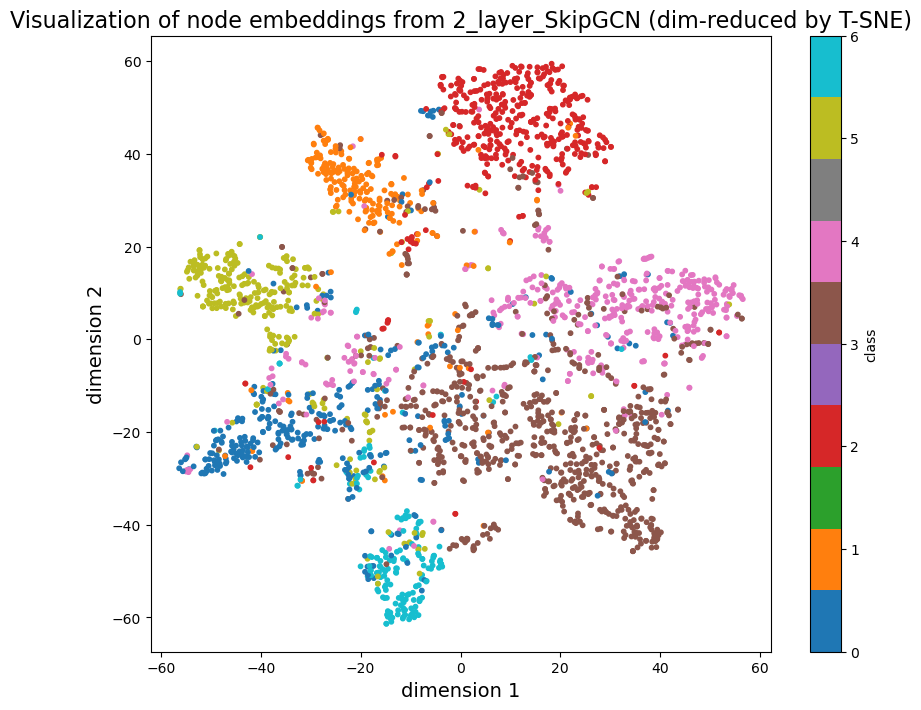

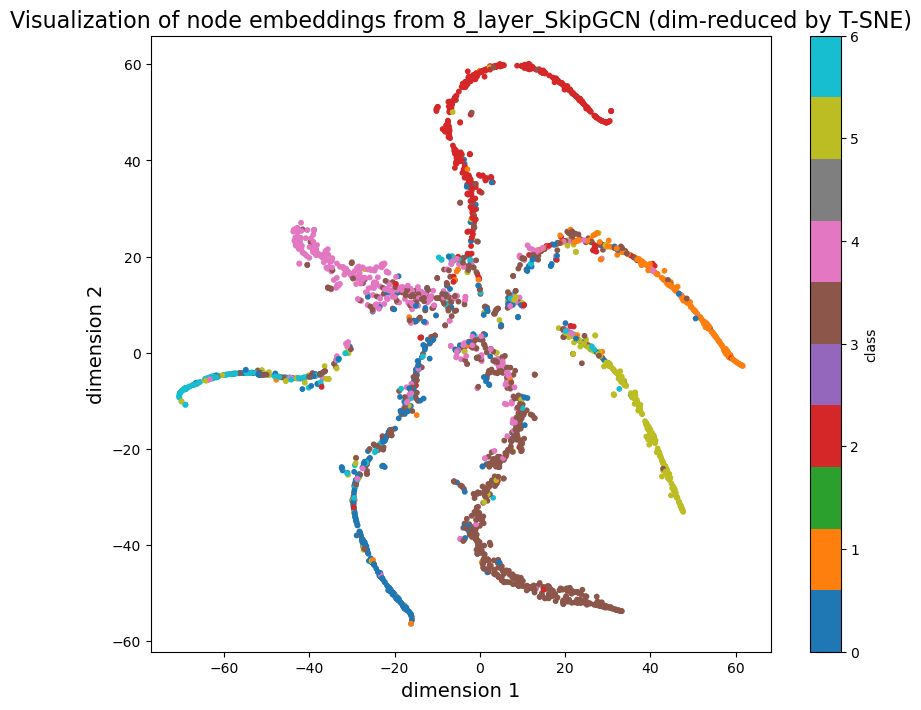

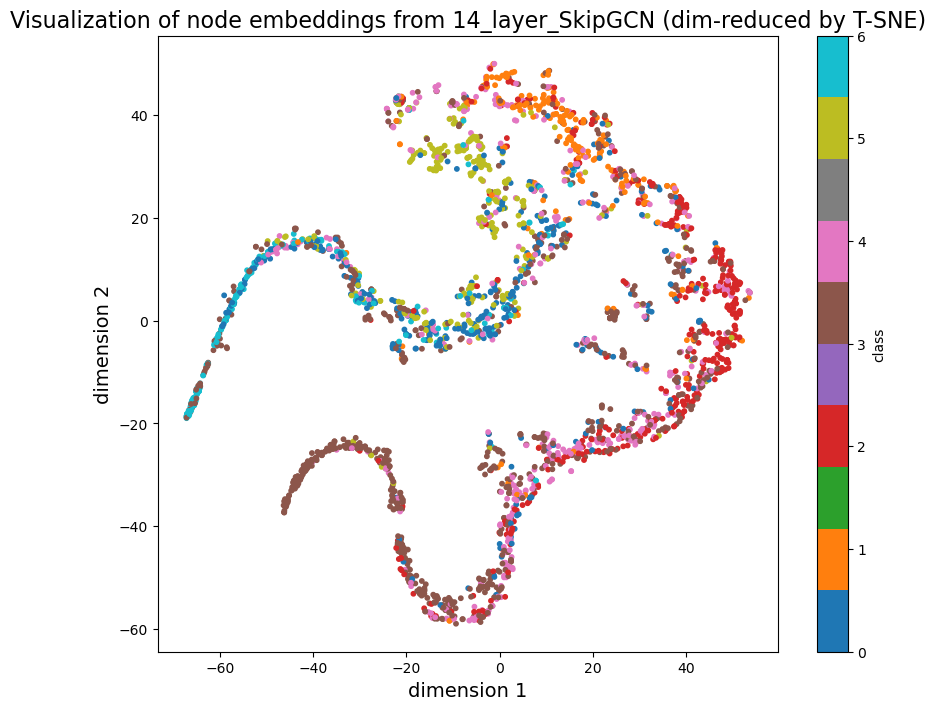

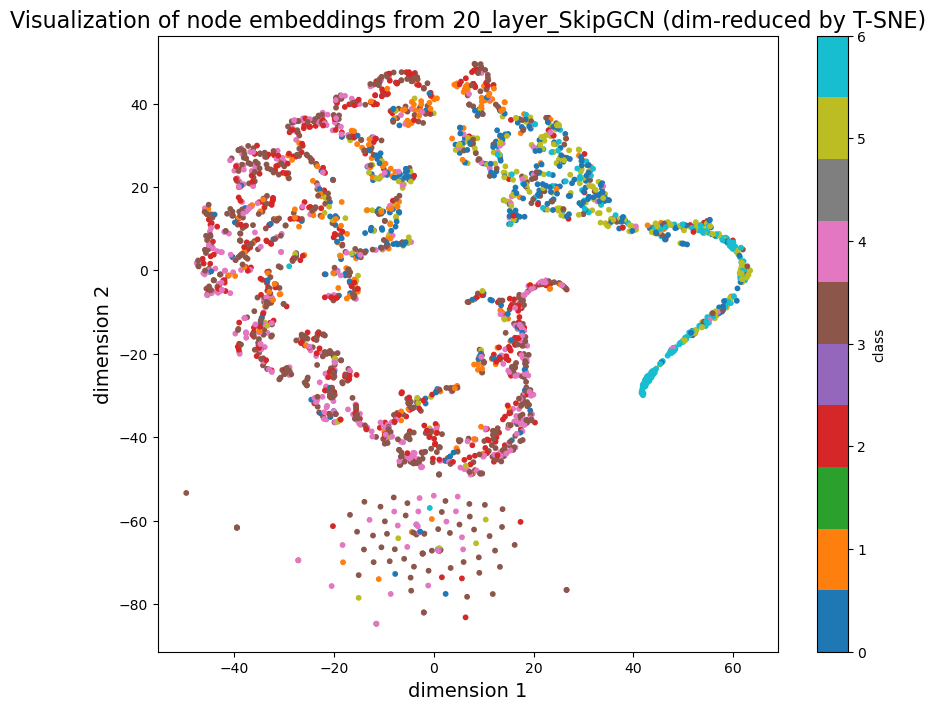

In [200]:
visualise_dimensions(sgcn_models, sgcn_training_params)

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data

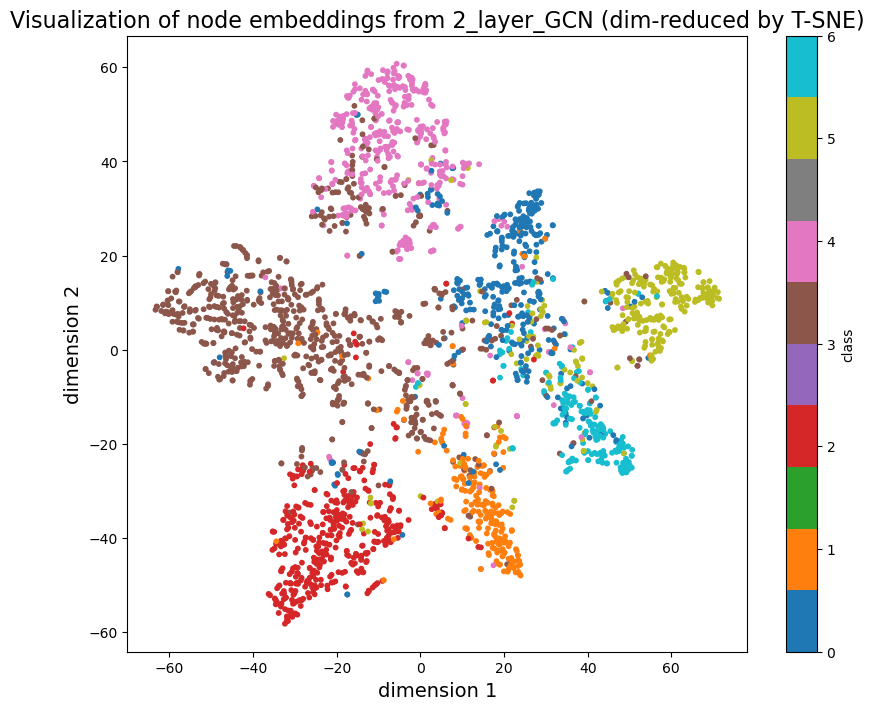

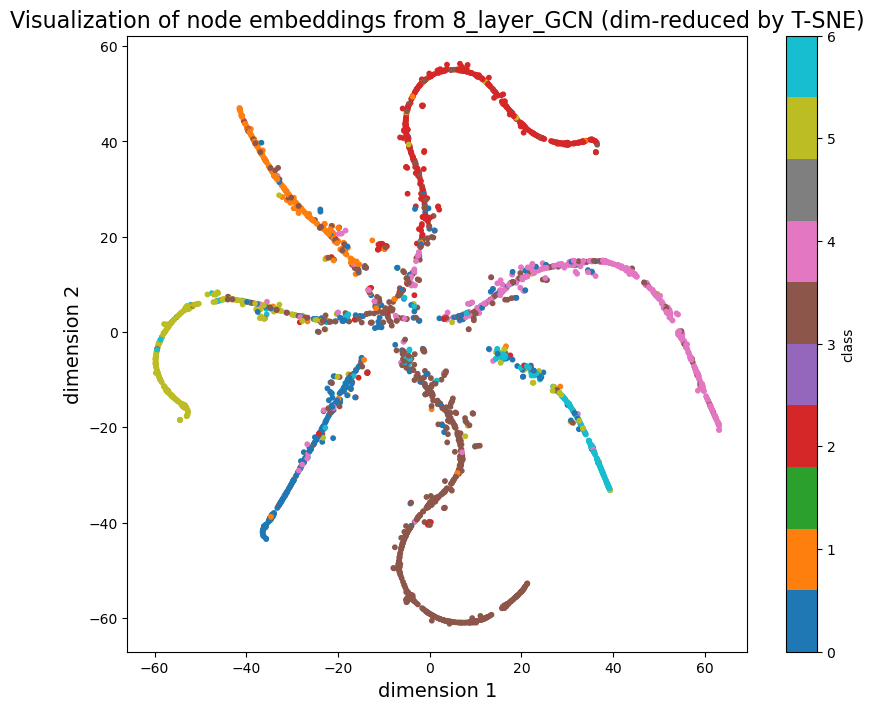

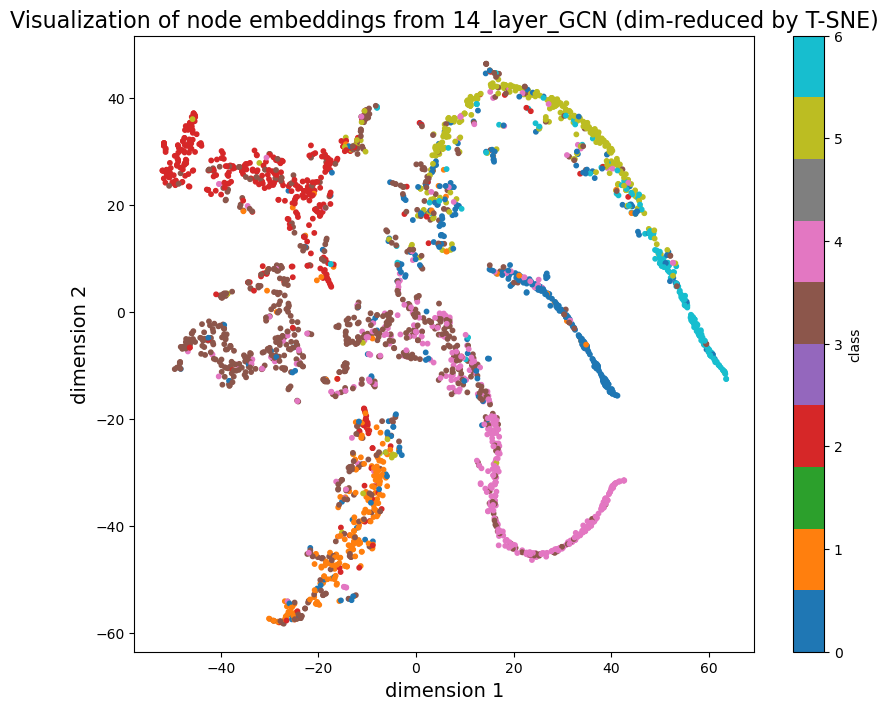

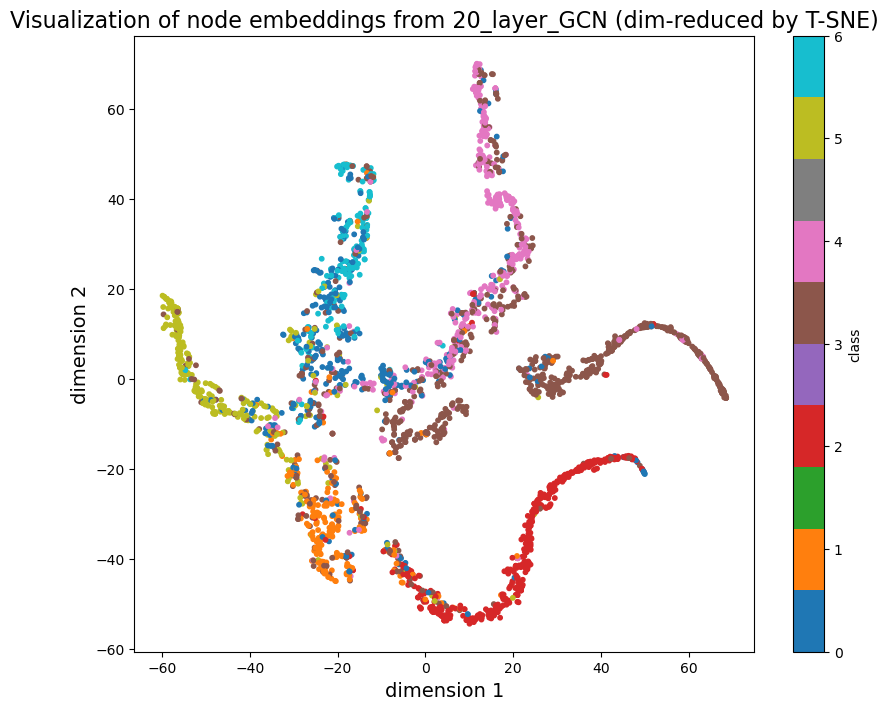

In [201]:
visualise_dimensions(gcn_models, gcn_training_params)

## Part 2. Skip-Connections

In this section, we will investigate whether skip-connections can alleviate the effect of over-smoothing.

#### a. Task 5) Setup graph convolutional network with skip-connections
Define a SkipGCN class for node classification that takes five inputs: *input_dim*, *hid_dim*, *n_class*, *n_layers*, and *dropout_ratio*. Using **residual connection** is recommended, but you may also use other techniques, like **concatenation**.

- Note that the `forward` function should return a Tensor object: **logits**, and the `generate_node_embeddings` fuction should return a Tensor object: **node_embeddings**, which is the representation of the last layer.
- For the case when the *n_layers=0*, implement a single feed-forward network.
- Use `F.relu` and `F.dropout` at the end of each layer.


## Optional) Jumping Knowledge Connection

#### a. Task6) Design Graph Convolutional Network with Jumping Knowledge Connection
Define a `JumpKnowGCN` class for a node classification that takes five inputs: *input_dim*, *hid_dim*, *n_class*, *n_layers*, and *dropout_ratio*. Using `max_pooling` is recommended but you may also use other differentiable functions.

- Note that the `forward` function should return a Tensor object: **logits** and the `generate_node_embeddings` fuction should return a Tensor object: **node_embeddings**, which is the representation of the last layer.
- For the case when the *n_layers=0*, implement a single feed-forward network.
- Use `relu` and `dropout` at the end of each layer.


#### b. Repeat experiments and Visualise the embeddings